# Hyperparameter Optimization with Optuna
Optimizing the Emotion Recognition CNN.

In [1]:
# Imports
import kagglehub
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import glob
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms, datasets
from sklearn.model_selection import train_test_split
import optuna
from tqdm import tqdm

# Setup Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [2]:
# Fixed settings
EPOCHS = 5
IMG_SIZE = 64
torch.manual_seed(42)
np.random.seed(42)

## Data Preparation
Reusing the data loading and splitting logic.

In [3]:
# Download and Setup Data
cache_path = kagglehub.dataset_download("samithsachidanandan/human-face-emotions")
data_dir = "data"

if not os.path.exists(data_dir) or not os.listdir(data_dir):
    shutil.copytree(cache_path, data_dir, dirs_exist_ok=True)
    print(f"Data copied to {data_dir}")
else:
    print(f"Data directory {data_dir} already exists and is not empty.")

data_dir = os.path.join(data_dir, "Data")

classes = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]
classes.sort()
print(f"Classes found: {classes}")

Using Colab cache for faster access to the 'human-face-emotions' dataset.
Data copied to data
Classes found: ['Angry', 'Fear', 'Happy', 'Sad', 'Suprise']


In [4]:
# Prepare file lists
class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
all_image_paths = []
all_labels = []

for class_name in classes:
    class_dir = os.path.join(data_dir, class_name)
    class_idx = class_to_idx[class_name]
    files = glob.glob(os.path.join(class_dir, "*.*"))
    valid_files = [f for f in files if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    for f in valid_files:
        all_image_paths.append(f)
        all_labels.append(class_idx)

# Split data
X_train, X_rest, y_train, y_rest = train_test_split(
        all_image_paths, all_labels, test_size=0.20, random_state=42, stratify=all_labels)
X_val, X_test, y_val, y_test = train_test_split(
        X_rest, y_rest, test_size=0.50, random_state=42, stratify=y_rest)

In [5]:
# Calculate class weights
class_counts = np.bincount(y_train)
total_samples = len(y_train)
class_weights = total_samples / (len(classes) * class_counts)
weights_tensor = torch.FloatTensor(class_weights).to(device)
print(f"Class weights: {class_weights}")

Class weights: [1.16479428 1.21446185 0.64102773 0.94162517 1.43661501]


In [6]:
class EmotionDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("L")
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

In [7]:
def get_data(params):
    batch_size = params['batch_size']

    train_transform = transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(10),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
        transforms.ToTensor(),
    ])

    val_transform = transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
    ])

    train_dataset = EmotionDataset(X_train, y_train, transform=train_transform)
    val_dataset = EmotionDataset(X_val, y_val, transform=val_transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

    return train_loader, val_loader

## Model Definition
Modified to accept hyperparameters.

In [8]:
class EmotionCNN(nn.Module):
    def __init__(self, num_classes, dropout_rate=0.5):
        super(EmotionCNN, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 4 * 4, 512),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

Trying a deeper CNN in VGG style, because performance of the shallow CNN is not good enough

In [9]:
class DeepEmotionCNN(nn.Module):
    def __init__(self, num_classes, dropout_rate=0.5):
        super(DeepEmotionCNN, self).__init__()

        self.block1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25)
        )

        self.block2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25)
        )

        self.block3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # 16 -> 8
            nn.Dropout(0.25)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 8 * 8, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.classifier(x)
        return x

In [10]:
def get_model(params):
    #model = EmotionCNN(num_classes=len(classes), dropout_rate=params['dropout_rate']).to(device)
    model = DeepEmotionCNN(num_classes=len(classes), dropout_rate=params['dropout_rate']).to(device)
    return model

In [11]:
def get_optimizer(model, params):
    optimizer_name = params['optimizer']
    learning_rate = params['learning_rate']
    weight_decay = params['weight_decay']

    if optimizer_name == 'Adam':
        return optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    elif optimizer_name == 'SGD':
        return optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    elif optimizer_name == 'RMSprop':
        return optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    else:
        raise ValueError(f"Unknown optimizer: {optimizer_name}")

## Training Loop with Pruning

In [12]:
def train(model, train_loader, val_loader, trial, params):
    criterion = nn.CrossEntropyLoss(weight=weights_tensor)
    optimizer = get_optimizer(model, params)

    accuracy_history = []

    for epoch in range(EPOCHS):
        model.train()
        training_loop = tqdm(train_loader)
        for images, labels in training_loop:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        # Validation
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        accuracy_history.append(accuracy)

        trial.report(accuracy, epoch)

        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return accuracy_history

## Optuna Objective

In [13]:
def objective(trial):
    params = {
        'batch_size': trial.suggest_categorical('batch_size', [32, 64, 128]),
        'dropout_rate': trial.suggest_float('dropout_rate', 0.2, 0.6),
        'optimizer': trial.suggest_categorical('optimizer', ['Adam', 'SGD', 'RMSprop']),
        'learning_rate': trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True),
        'weight_decay': trial.suggest_float('weight_decay', 1e-6, 1e-3, log=True),
    }

    model = get_model(params)
    train_loader, val_loader = get_data(params)

    history = train(model, train_loader, val_loader, trial, params)

    return history[-1]

## Run Optimization

In [14]:
study = optuna.create_study(
    direction='maximize',
    sampler=optuna.samplers.TPESampler(seed=42),
    pruner=optuna.pruners.MedianPruner(),
    study_name='emotion_cnn_optimization',
    storage='sqlite:///emotion_optimization.db',
    load_if_exists=True
)

[I 2025-11-23 16:34:47,807] A new study created in RDB with name: emotion_cnn_optimization


In [15]:
study.optimize(objective, n_trials=20)

100%|██████████| 739/739 [01:51<00:00,  6.61it/s]
[I 2025-11-23 16:45:20,682] Trial 0 finished with value: 62.944162436548226 and parameters: {'batch_size': 64, 'dropout_rate': 0.4394633936788146, 'optimizer': 'Adam', 'learning_rate': 0.003967605077052989, 'weight_decay': 6.358358856676247e-05}. Best is trial 0 with value: 62.944162436548226.
100%|██████████| 370/370 [01:49<00:00,  3.39it/s]
[I 2025-11-23 16:55:33,932] Trial 1 finished with value: 63.367174280879865 and parameters: {'batch_size': 128, 'dropout_rate': 0.5329770563201687, 'optimizer': 'Adam', 'learning_rate': 8.17949947521167e-05, 'weight_decay': 3.752055855124284e-05}. Best is trial 1 with value: 63.367174280879865.
100%|██████████| 370/370 [01:49<00:00,  3.39it/s]
[I 2025-11-23 17:05:43,461] Trial 2 finished with value: 62.04737732656515 and parameters: {'batch_size': 128, 'dropout_rate': 0.25579754426081674, 'optimizer': 'RMSprop', 'learning_rate': 0.0022673986523780395, 'weight_decay': 3.972110727381911e-06}. Best is

In [16]:
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Best trial:
  Value: 69.44162436548223
  Params: 
    batch_size: 64
    dropout_rate: 0.20433036880014452
    optimizer: RMSprop
    learning_rate: 0.0006419477767410103
    weight_decay: 1.4547307271298078e-05


## Visualization

/tmp/ipython-input-1791146102.py:1: ExperimentalWarning: optuna.visualization.matplotlib._optimization_history.plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study)


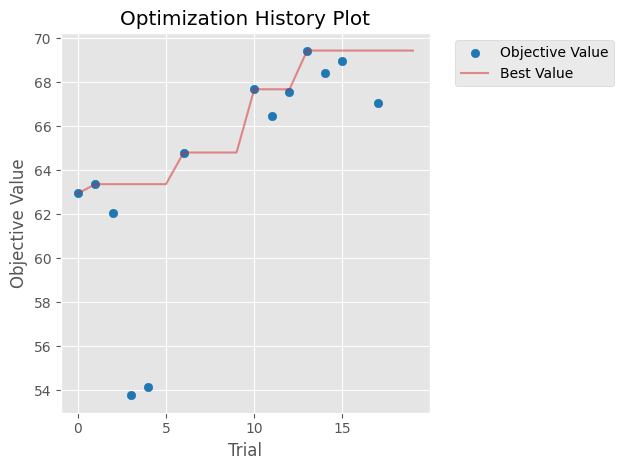

In [17]:
optuna.visualization.matplotlib.plot_optimization_history(study)
plt.show()


/tmp/ipython-input-2472360306.py:1: ExperimentalWarning: optuna.visualization.matplotlib._param_importances.plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_param_importances(study)


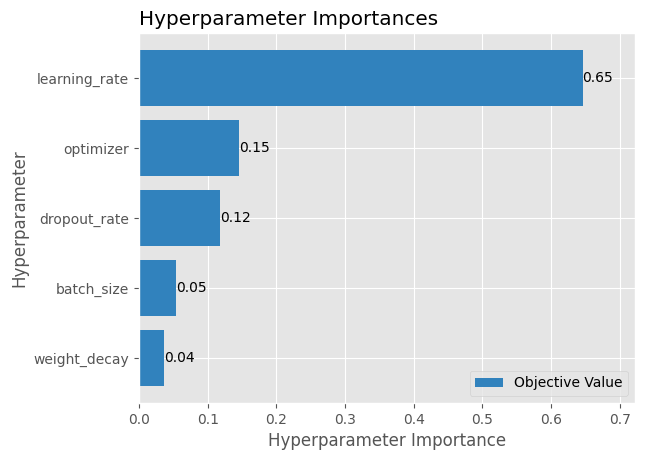

In [18]:
optuna.visualization.matplotlib.plot_param_importances(study)
plt.show()
